In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyslalib import slalib
import random
import scipy.optimize as op
%matplotlib inline

In [5]:
start, end = 6000,7000
cadence = 2
t0 = 6500 #random.uniform(start,end)
u0 = 0.05 #random.uniform(-3,3)
tE = 30 #random.uniform(10,30)
f_s = 0.5
pi_n = 0.1 #random.uniform(-0.1,0.1)
pi_e = 0.1 #random.uniform(-0.1,0.1)
print pi_n,pi_e
error = 0.1
ra =270
dec = -30
mag = 23
filt = 'z'
sigma_sys = 0.005 #magnitude
tbl = np.array([['u',0.038,23.78],['g',0.039,24.81],['r',0.039,24.81],['i',0.039,23.92],['z',0.039,23.34],['y',0.039,22.45]])




0.1 0.1


In [6]:
def baseline_generator (start,end, cadence):
    
    num = np.int((end-start) / cadence)
    #print num
    
    return np.linspace(start,end,num)

def error_generator (m,filt,sigma_sys,tbl):
    for i in range (len(tbl)):
        if filt == tbl[i][0]:
            gamma = np.float(tbl[i][1])
            mag5 = np.float(tbl[i][2])
            
           
    x = 10**(0.4*(m-mag5))
    sigma_rand = (0.04-gamma)*x + gamma* (x**2)
    sigma_sqr = sigma_sys**2 + sigma_rand**2
    mag_err = m + np.random.normal(loc=0, scale = np.sqrt(sigma_sqr ))
    return mag_err    
            
def PSPL_mag_no_parallax (t, t0, u0, tE, f_s):
    
    u = np.sqrt(u0**2 + ((t-t0)/tE)**2)
    A = (u **2 + 2)/ (u * np.sqrt( u**2 + 4))
    #A = A + 0.1* random.uniform(0,1)
    
    return f_s * A + (1-f_s)
    
def u0_parallax (t,t0, ra , dec,pi_n, pi_e):                                                       
    north, east =  North_East_vectors_target(ra,dec)
    delta_s = annual_parallax (t, east,north, t0)
    return delta_s[0]*pi_n + delta_s[1]*pi_e , -1*delta_s[0]*pi_e + delta_s[1]*pi_n
    
def PSPL_mag_with_parallax (t, t0, u0, tE, f_s,pi_n,pi_e,ra, dec):
    
    u = np.sqrt((u0+u0_parallax (t,t0, ra , dec,pi_n, pi_e)[1])**2 + (((t-t0)/tE)+u0_parallax (t,t0, ra , dec,pi_n, pi_e)[0])**2)
    A = (u **2 + 2)/ (u * np.sqrt( u**2 + 4))
    #A = A + 0.1* random.uniform(0,1)
    
    return f_s * A + (1-f_s)    

def A_to_m (A, mag): # converts magnification to magnitude having the baseline magnitude
    return mag - 2.5* np.log10 (A)            

def m_to_A (m, mag): # converts magnitude to magnification having the baseline magnitude
    return 10 ** ((m-mag)/(-2.5))
                                        
def lnlike_no_parallax(theta, t, f, f_err):
    t0, u0, tE,f_s = theta
    model = PSPL_mag_no_parallax(t,t0, u0, tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return 0.5*(np.sum((f-model)**2*inv_sigma2))

def fit_no_parallax(t,f,err,t0, u0, tE,f_s):
    nll = lambda *args: lnlike_no_parallax(*args)
    result = op.minimize(nll, [t0, u0, tE,f_s], args=(t,f,err),method = 'Nelder-Mead')
    print result['fun']
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    return result['x']

def lnlike_with_parallax(theta, t, f, f_err):
    t0, u0, tE,f_s, pi_n, pi_e = theta
    ra , dec = 270,-30
    model = PSPL_mag_with_parallax(t,t0, u0, tE,f_s,pi_n, pi_e, ra, dec)
    inv_sigma2 = 1.0/(f_err**2)
    return 0.5*(np.sum((f-model)**2*inv_sigma2))

def fit_with_parallax(t,f,err,t0, u0, tE,f_s,pi_n,pi_e):
    nll = lambda *args: lnlike_with_parallax(*args)
    result = op.minimize(nll, [t0, u0, tE,f_s,pi_n,pi_e], args=(t,f,err),method = 'Nelder-Mead')
    print result['fun']
    t0_ml, u0_ml, tE_ml,f_s_ml,pi_n_ml, pi_e_ml = result['x']
    return result['x']

def North_East_vectors_target(ra,dec):
    
    """
    This function define the North and East vectors projected on the sky plane
    perpendicular to the line
    of sight (i.e the line define by RA,DEC of the event).
    """
    target_angles_in_the_sky = [ra * np.pi / 180 , dec * np.pi / 180]
    Target = np.array([np.cos(target_angles_in_the_sky[1]) * np.cos(target_angles_in_the_sky[0]), np.cos(target_angles_in_the_sky[1]) * np.sin(target_angles_in_the_sky[0]), np.sin(target_angles_in_the_sky[1])])
        
    East = np.array([-np.sin(target_angles_in_the_sky[0]), np.cos(target_angles_in_the_sky[0]), 0.0])
    North = np.cross(Target, East)           
    return North, East

                                            
def annual_parallax (t, East,North,t0):
    to_par_mjd = t - 0.5
    t0 = t0 - 0.5
    Earth_position_time_reference = slalib.sla_epv(to_par_mjd)
    Sun_position_time_reference = -Earth_position_time_reference[0]
    Sun_speed_time_reference = -Earth_position_time_reference[1]
    delta_Sun = []
    for time_ in to_par_mjd:
        time_mjd = time_ - 0.5

        Earth_position = slalib.sla_epv(time_mjd)
        Sun_position = -Earth_position[0]
        delta_sun = Sun_position - (time_mjd - t0) * Sun_speed_time_reference - Sun_position_time_reference

        delta_Sun.append(delta_sun.tolist())

    delta_Sun = np.array(delta_Sun)

    delta_Sun_projected = np.array(
            [np.dot(delta_Sun, North), np.dot(delta_Sun, East)])

    return delta_Sun_projected

                                                                                                                                                                        
def plot (t,data,fun,res,style_data,style_fun,style_res,xlim):
    
    left, width = 0.1, 0.8
    bottom, height_1,height_2 = 0.12,0.2, 0.65
    bottom_2 = bottom+ height_1
    
    rect_1 = [left, bottom, width, height_1]
    rect_2 = [left, bottom_2, width, height_2]                                            
                                                        
 
                                                            
    residual = plt.axes(rect_1)
    main = plt.axes(rect_2)     
    main.plot(t,data,str(style_data),t,fun,str(style_fun))
    main.axes.get_xaxis().set_ticks([])
    main.set_ylabel('Magnitude')
    main.tick_params(axis='y')
    main.set_ylim(max(data),min(data)-0.5)
    main.set_xlim(xlim[0],xlim[1])
    residual.plot(t,res,str(style_res))
    residual.set_xlabel('Time(Days)')
    residual.tick_params(axis='both')
    residual.set_xlim(xlim[0],xlim[1])
    
    
    
                                                                                                                                    
    
    return

3845.827759978857
3825.377613259134
done


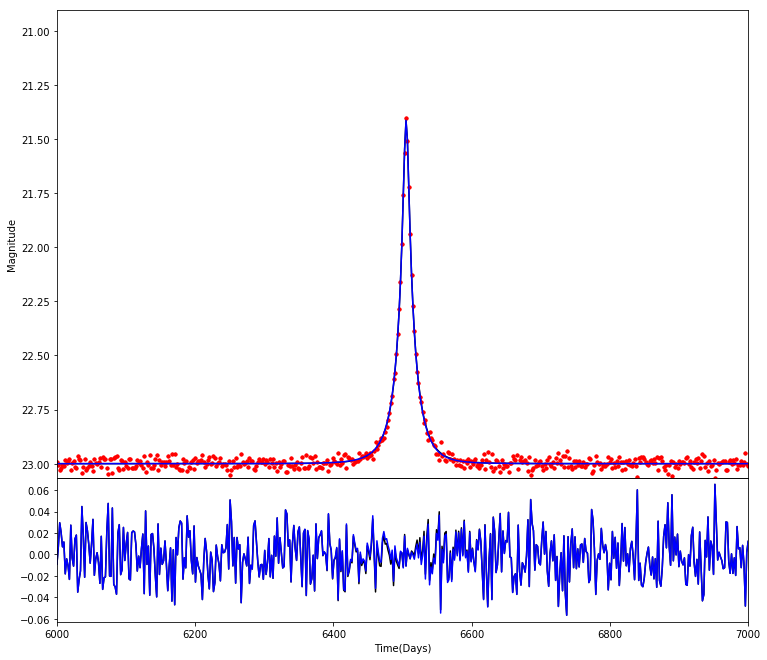

In [7]:
plt.close()
plt.figure(1)


t = baseline_generator (start,end, cadence)
A_no_parallax = PSPL_mag_no_parallax (t, t0, u0, tE, f_s)
A_with_parallax = PSPL_mag_with_parallax (t, t0, u0, tE, f_s,pi_n,pi_e,ra, dec)
mag_no_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
mag_with_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
fitted_param_no = fit_no_parallax(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s)
fitted_param_with = fit_with_parallax(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s,pi_n,pi_e)
mag_fit_no_parallax = A_to_m(PSPL_mag_no_parallax (t,fitted_param_no[0],fitted_param_no[1],fitted_param_no[2],fitted_param_no[3]),mag)
mag_fit_with_parallax = A_to_m(PSPL_mag_with_parallax (t,fitted_param_with[0],fitted_param_with[1],fitted_param_with[2],fitted_param_with[3],fitted_param_with[4],fitted_param_with[5], ra, dec),mag)

'''
plt.plot(t,mag_with_parallax,'b.',t,mag_fit_no_parallax,'r-')
plt.gca().invert_yaxis()

plt.figure(2)
plt.plot(t,mag_with_parallax- mag_fit_no_parallax ,'r.')
'''

plot(t,mag_with_parallax,mag_fit_no_parallax,mag_with_parallax - mag_fit_no_parallax,'r.','k-','k',xlim=np.array([6000,7000]))

plot(t,mag_with_parallax,mag_fit_with_parallax,mag_with_parallax - mag_fit_with_parallax,'r.','b-','b',xlim=np.array([6000,7000]))

fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

print 'done'

In [63]:
def fit_no_parallax_returns_chi_squared(t,f,err,t0, u0, tE,f_s):
    nll = lambda *args: lnlike_no_parallax(*args)
    result = op.minimize(nll, [t0, u0, tE,f_s], args=(t,f,err),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    return result['fun']

def fit_with_parallax_returns_chi_squared(t,f,err,t0, u0, tE,f_s,pi_n,pi_e):
    nll = lambda *args: lnlike_with_parallax(*args)
    result = op.minimize(nll, [t0, u0, tE,f_s,pi_n,pi_e], args=(t,f,err),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml,pi_n_ml, pi_e_ml = result['x']
    return result['fun']

In [25]:
cadence_trial = np.linspace(0.1,5,20) #np.array([0.2,0.5,1,2,3,4])
u0_trial = np.array([0.01,0.03,0.05,0.07,0.09])
tE_trial = np.array([10,20,30,40,50,60,70])
result = {}
steps = 0

for tE in tE_trial:
    tE_ = []
    print steps
    for u0 in u0_trial:
        cadence_ = []
        for i in range(len(cadence_trial)):
            t = baseline_generator (start,end, cadence_trial[i])
            A_no_parallax = PSPL_mag_no_parallax (t, t0, u0, tE, f_s)
            A_with_parallax = PSPL_mag_with_parallax (t, t0, u0, tE, f_s,pi_n,pi_e,ra, dec)
            mag_no_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
            mag_with_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
            chi_squared_no = fit_no_parallax_returns_chi_squared(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s)
            chi_squared_with = fit_with_parallax_returns_chi_squared(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s,pi_n,pi_e)
            cadence_.append(chi_squared_no-chi_squared_with)
            
        result['uo='+str(u0)+'_and_tE='+str(tE)]= np.asarray(cadence_)
        tE_.append(cadence_)

    result['tE='+str(tE)]= np.asarray(tE_)
    steps = steps +1

0
1
2
3
4
5
6


In [29]:
result['tE=20'][0]

array([1.53210921e+02, 1.62268770e+04, 1.34750610e+06, 4.35373718e+04,
       7.44812228e+05, 6.24917857e+05, 5.11452290e+05, 8.00062050e+03,
       3.97147452e+05, 4.83268369e+00, 1.71723979e+04, 2.66334827e+05,
       2.63276972e+03, 2.39638580e+05, 2.25555218e+05, 2.90043265e+03,
       2.88664871e+03, 6.82570986e+03, 3.98708575e+03, 1.65444916e+05])

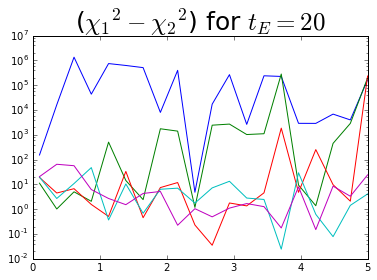

In [37]:
for i in range(len(u0_trial)):
    plt.plot(cadence_trial, result['tE=20'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 20$',size = '25')

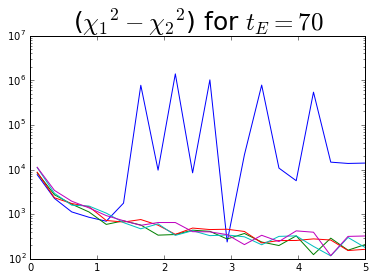

In [38]:
for i in range(len(u0_trial)):
    plt.plot(cadence_trial, result['tE=70'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 70$',size = '25')

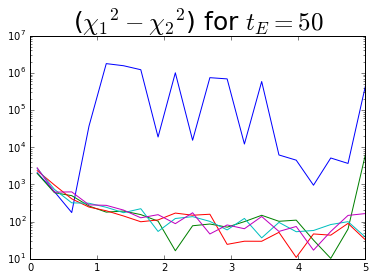

In [39]:
for i in range(len(u0_trial)):
    plt.plot(cadence_trial, result['tE=50'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 50$',size = '25')

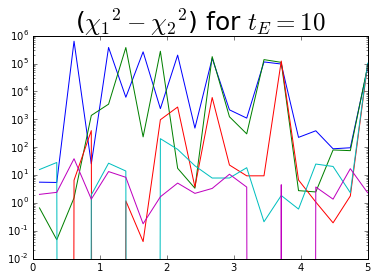

In [40]:
for i in range(len(u0_trial)):
    plt.plot(cadence_trial, result['tE=10'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 10$',size = '25')

In [45]:
import json
  
#json = json.dumps(result)
f = open("result1.txt","w")
f.write( str(result) )
f.close()

In [64]:
cadence_trial = np.linspace(0.1,5,20) #np.array([0.2,0.5,1,2,3,4])
dp_per_tE = np.linspace(2,15,14) #np.array([3, 5, 7, 8, 10, 15])
u0_trial = np.array([0.01,0.03,0.05,0.07,0.09])
tE_trial = np.array([10,20,30,40,50,60,70]) # in days
result = {}
steps = 0

for tE in tE_trial:
    tE_ = []
    print steps
    for u0 in u0_trial:
        cadence_ = []
        for i in range(len(dp_per_tE)):
            t = baseline_generator (start,end, (tE/dp_per_tE[i]))
            A_no_parallax = PSPL_mag_no_parallax (t, t0, u0, tE, f_s)
            A_with_parallax = PSPL_mag_with_parallax (t, t0, u0, tE, f_s,pi_n,pi_e,ra, dec)
            mag_no_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
            mag_with_parallax = error_generator (A_to_m(A_with_parallax,mag),filt,sigma_sys,tbl)
            chi_squared_no = fit_no_parallax_returns_chi_squared(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s)
            chi_squared_with = fit_with_parallax_returns_chi_squared(t,m_to_A(mag_with_parallax,mag),sigma_sys,t0, u0, tE,f_s,pi_n,pi_e)
            cadence_.append(chi_squared_no-chi_squared_with)
            
        result['uo='+str(u0)+'_and_tE='+str(tE)]= np.asarray(cadence_)
        tE_.append(cadence_)

    result['tE='+str(tE)]= np.asarray(tE_)
    steps = steps +1

0
1
2
3
4
5
6


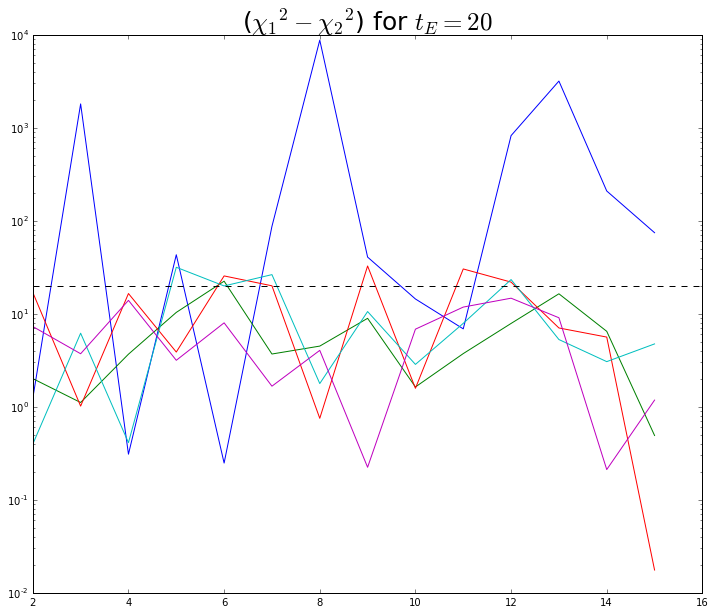

In [76]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=20'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 20$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

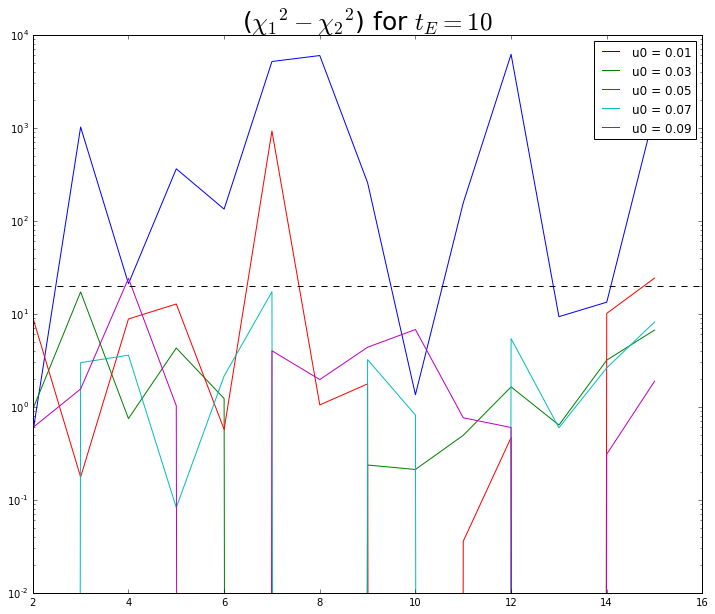

In [77]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=10'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 10$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

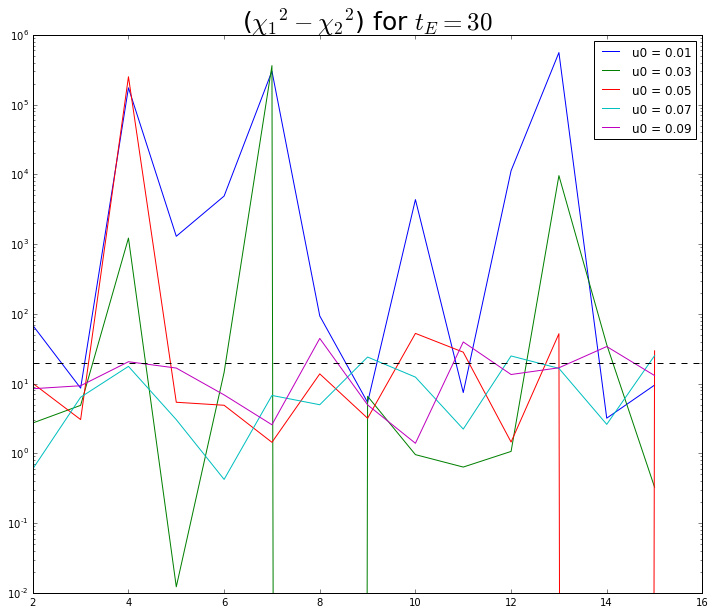

In [78]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=30'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 30$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

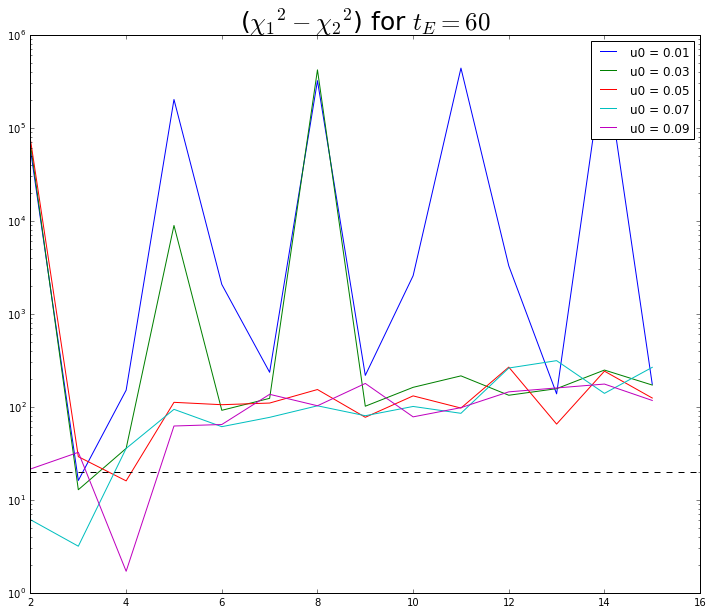

In [79]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=60'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 60$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

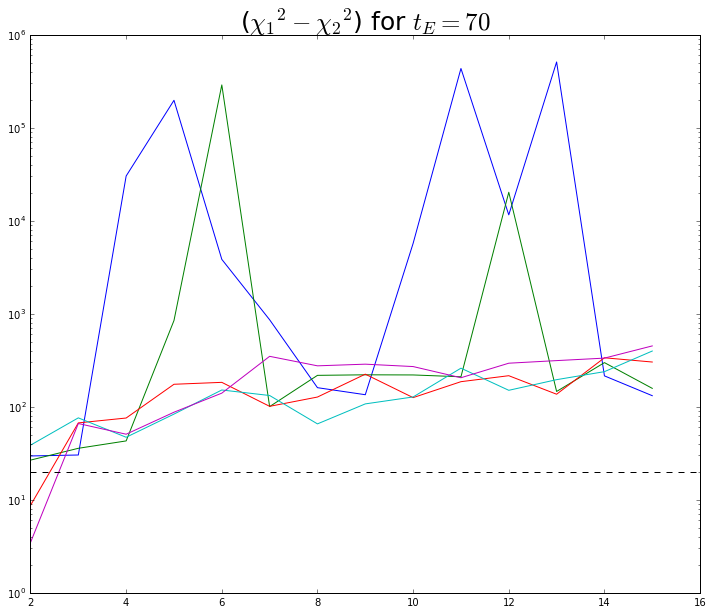

In [80]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=70'][i],label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
#plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 70$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)


In [70]:
f = open("result3.txt","w")
f.write( str(result) )
f.close()

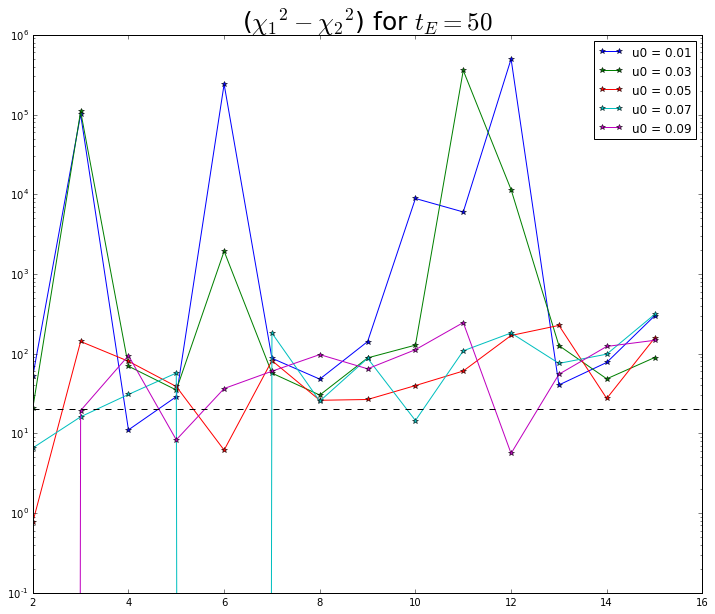

In [81]:
for i in range(len(u0_trial)):
    plt.plot(dp_per_tE, result['tE=50'][i],'*-',label='u0 = '+str(u0_trial[i]))
plt.yscale('log')
plt.legend()
plt.title('('+'${{\chi}_1}^2 - {{\chi}_2}^2$'+') for '+'$t_E = 50$',size = '25')
plt.axhline(y=20, color='black', linestyle = '--')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)